# Statistical language modeling
In this experiment, we look into the unigram and bigram model - its performance and disadvantages.

The file hw4_vocab.txt contains a list of 500 tokens, corresponding to words, punctuation symbols, and other textual markers.

The file hw4_unigram.txt contains the counts of each of these tokens in a large text corpus of Wall Street Journal articles.  The corpus consisted of roughly 3 million sentences.

The file hw4_bigram.txt contains the counts of pairs of adjacent words in this same corpus.  Let count(w1,w2) denote the number of times that word w1 is followed by word w2.  The counts are stored in a simple three column format: 

  index(w1)  index(w2)  count(w1,w2)

In [181]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import string
import numpy as np
import csv
import matplotlib.pyplot as plt

In [182]:
df_word=pd.read_csv('hw4_vocab.txt',sep =' ',names =['Word'],quoting=csv.QUOTE_NONE)
df_uni=pd.read_csv('hw4_unigram.txt',sep =' ',names =['Count'])
df_bi=pd.read_csv('hw4_bigram.txt',sep ='\t',names =['Index 1', 'Index 2','Count'])

In [183]:
df_uni = pd.concat([df_word,df_uni],axis=1)

In [184]:
df_bi[['Index 1', 'Index 2']] -= 1 # Python index start from 0
df_bi['Word 1'] = df_word['Word'][df_bi['Index 1']].values
df_bi['Word 2'] = df_word['Word'][df_bi['Index 2']].values
df_bi=df_bi[['Index 1','Index 2','Word 1','Word 2','Count']]

## Maximum likelihood estimate of the unigram distribution $P_u(w)$ over words $w$.

In [185]:
total_sum = df_uni['Count'].sum()
df_uni['prob']=df_uni['Count']/total_sum
df_uni[df_uni['Word'].str.startswith('M')]

,Word,Count,prob
53,MILLION,169479,0.002073
68,MORE,139728,0.001709
76,MR.,117873,0.001442
120,MOST,64424,0.000788
121,MARKET,63807,0.000780
125,MAY,59680,0.000730
129,M.,57514,0.000703
130,MANY,56968,0.000697
158,MADE,45777,0.000560
177,MUCH,42076,0.000515


## Ten most likely words to follow the word 'THE'

In [186]:
df_bi['net count'] = df_bi.groupby('Index 1')['Count'].transform('sum')
df_bi['p_w2_w1']=df_bi['Count']/df_bi['net count']
df_bi[df_bi['Word 1'] == 'THE'].sort_values(by=['p_w2_w1'],ascending=False).head(10)

,Index 1,Index 2,Word 1,Word 2,Count,net count,p_w2_w1
993,3,0,THE,<UNK>,2371132,3855375,0.615020
1058,3,69,THE,U.,51556,3855375,0.013372
1064,3,78,THE,FIRST,45186,3855375,0.011720
1060,3,72,THE,COMPANY,44949,3855375,0.011659
1050,3,60,THE,NEW,36439,3855375,0.009451
1165,3,183,THE,UNITED,33435,3855375,0.008672
1086,3,102,THE,GOVERNMENT,26230,3855375,0.006803
1029,3,38,THE,NINETEEN,25641,3855375,0.006651
1282,3,307,THE,SAME,24239,3855375,0.006287
1014,3,22,THE,TWO,23752,3855375,0.006161


In [187]:
def unigram_likelihood(sent,df_U):
    sent_list=sent.split()
    sent_list = [word.upper() for word in sent_list]

    # Filter the DataFrame to include only words in sent_list
    filtered_df = df_U[df_U['Word'].isin(sent_list)]

    # Create a categorical type for ordering
    filtered_df['Word'] = pd.Categorical(filtered_df['Word'], categories=sent_list, ordered=True)

    # Sort the filtered DataFrame based on the ordered categorical 'Word'
    sorted_filtered_df = filtered_df.sort_values('Word').reset_index(drop=True)
    
    print(sorted_filtered_df)
    
    prob_vec=sorted_filtered_df['prob'].values
    
    return prob_vec

In [188]:
def bigram_likelihood(sent,df_B):
    sent_list=sent.split()
    sent_list = [word.upper() for word in sent_list]
    sent_list.insert(0,'<s>')
    
    sent_list_prior = sent_list[:-1]  # Removes first element
    sent_list_follow = sent_list[1:] # Removes last element
    
    #combined_mask = pd.Series([False] * len(df_B))
    prob_vec = []
    for i in list(range(len(sent_list)-1)):
        current_mask = (df_B['Word 1'] == sent_list_prior[i]) & (df_B['Word 2'] == sent_list_follow[i])
        print(df_B[current_mask].values)
        if(not current_mask.any()):
            prob_vec.append(1e-10)  # Probability smaller than smallest available in the training
            continue   
        #combined_mask = combined_mask | current_mask
        prob_vec.append(df_B[current_mask]['p_w2_w1'].values[0])
 
    return np.array(prob_vec)

## Consider the sentence “The stock market fell by one hundred points last week”. Which model yields the highest log-likelihood?

In [189]:
s1='The stock market fell by one hundred points last week'

In [190]:
print('\nThe unigram model log likelihood is',sum(np.log(unigram_likelihood(s1,df_uni))))

      Word    Count      prob
0      THE  3855375  0.047152
1    STOCK    54645  0.000668
2   MARKET    63807  0.000780
3     FELL    21634  0.000265
4       BY   341800  0.004180
5      ONE   491054  0.006006
6  HUNDRED   328791  0.004021
7   POINTS    18060  0.000221
8     LAST    94889  0.001161
9     WEEK    46795  0.000572

The unigram model log likelihood is -64.50944034364878


In [191]:
print('\nThe bigram model log likelihood is',sum(np.log(bigram_likelihood(s1,df_bi))))

[[1 3 '<s>' 'THE' 479427 3021866 0.15865263383617936]]
[[3 132 'THE' 'STOCK' 8982 3855375 0.0023297344616282465]]
[[132 121 'STOCK' 'MARKET' 5648 54645 0.10335803824686614]]
[[121 376 'MARKET' 'FELL' 135 63807 0.0021157553246509003]]
[[376 25 'FELL' 'BY' 467 21634 0.021586391790699825]]
[[25 16 'BY' 'ONE' 2795 341800 0.008177296664716208]]
[[16 26 'ONE' 'HUNDRED' 102660 491054 0.2090605106566691]]
[[26 439 'HUNDRED' 'POINTS' 200 328791 0.0006082891563333546]]
[[439 88 'POINTS' 'LAST' 103 18060 0.005703211517165006]]
[[88 155 'LAST' 'WEEK' 15554 94889 0.1639178408456196]]

The bigram model log likelihood is -40.91813213378977


In this case, the bigram model yields the highest log-likelihood

## Consider the sentence “The sixteen officials sold fire insurance”. Which pairs of adjacent words in this sentence are not observed in the training corpus? What effect does this have on the log-likelihood from the bigram model?

In [192]:
s2='The sixteen officials sold fire insurance'

In [193]:
print('\nThe unigram model log likelihood is',sum(np.log(unigram_likelihood(s2,df_uni))))

        Word    Count      prob
0        THE  3855375  0.047152
1    SIXTEEN    16540  0.000202
2  OFFICIALS    54572  0.000667
3       SOLD    16573  0.000203
4       FIRE    17691  0.000216
5  INSURANCE    17019  0.000208

The unigram model log likelihood is -44.291934473132606


In [194]:
print('\nThe bigram model log likelihood is',sum(np.log(bigram_likelihood(s2,df_bi))))

[[1 3 '<s>' 'THE' 479427 3021866 0.15865263383617936]]
[[3 498 'THE' 'SIXTEEN' 881 3855375 0.0002285121421392212]]
[]
[[133 499 'OFFICIALS' 'SOLD' 5 54572 9.162207725573554e-05]]
[]
[[443 488 'FIRE' 'INSURANCE' 54 17691 0.003052399525182296]]

The bigram model log likelihood is -71.36632679534989


The pairs {'SIXTEEN','OFFICIALS'} and {'SOLD','FIRE'} are not present in the database. Since these pairs are not observed in the training corpus, ideally 0 probability must be assigned, but it leads to $-\infty$ likelihood. To avoid that, a very small probability of $10^{-10}$ is assigned to each pair. Since these two pairs are not observed, the bigram model assigs very less log likelihood to the sentence as compared to the unigram model.

## Mixture model
Consider the so-called mixture model that predicts words from a weighted interpolation of the unigram
and bigram models: $$P_m(w′|w) = \lambda P_u(w′) + (1 − \lambda)P_b(w′|w)$$ where $\lambda \in [0, 1]$. Compute and plot the value of the log-likelihood as a function of the parameter $\lambda \in [0, 1]$. From your results, deduce the optimal value of λ to two significant digits

In [195]:
def mixture_likelihood(sent,df_U,df_B):
    
    prob_vec_uni= unigram_likelihood(sent,df_U)
    
    print('\n')
    
    prob_vec_bi = bigram_likelihood(sent,df_B)
    
    print('\n')
    
    prob_mix = []
    
    lam_vec = np.linspace(0,1,101)
    
    for lam in lam_vec :
        prob_vec_mix = lam*prob_vec_uni+(1-lam)*prob_vec_bi
        prob_mix.append(sum(np.log(prob_vec_mix)))
  
    plt.plot(lam_vec,np.transpose(prob_mix))
    plt.title('Log likelihood of mixture model as a function of $\lambda$')  # Title of the plot
    plt.xlabel('$\lambda$')  # Label for x-axis
    plt.ylabel('log-likelihood')  # Label for y-axis
    plt.grid()  # Show grid
    plt.show()  # Display the plot
    
    max_ind=np.argmax(prob_mix)
    max_lam=lam_vec[max_ind]
        
    print('The maximum log likelihood for mixture model is',prob_mix[max_ind],', happens at \u03BB =',max_lam)

        Word    Count      prob
0        THE  3855375  0.047152
1    SIXTEEN    16540  0.000202
2  OFFICIALS    54572  0.000667
3       SOLD    16573  0.000203
4       FIRE    17691  0.000216
5  INSURANCE    17019  0.000208


[[1 3 '<s>' 'THE' 479427 3021866 0.15865263383617936]]
[[3 498 'THE' 'SIXTEEN' 881 3855375 0.0002285121421392212]]
[]
[[133 499 'OFFICIALS' 'SOLD' 5 54572 9.162207725573554e-05]]
[]
[[443 488 'FIRE' 'INSURANCE' 54 17691 0.003052399525182296]]




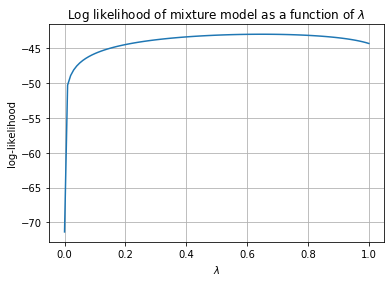

The maximum log likelihood for mixture model is -42.96416395341745 , happens at λ = 0.65


In [196]:
mixture_likelihood(s2,df_uni,df_bi)